In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import torch.nn as nn
from collections import deque
from tqdm.notebook import tqdm
import random
import math
from IPython.display import clear_output
from gymnasium.wrappers import AtariPreprocessing

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [4]:
np.zeros(200).shape

(200,)

# Prioritized experience replay buffer

In [6]:
class ReplayBuffer():
    def __init__(self,max_capacity = 2000,batch_size = 4):
        self.max_capacity = max_capacity
        self.buffer = []
        self.batch_size = batch_size
        self.priority = np.zeros((self.max_capacity),dtype = np.float32)
        self.pos = 0
    def add(self,state,action,reward,next_state,done):
        state = np.expand_dims(state,axis=0)
        next_state = np.expand_dims(next_state,axis=0)
        max_priority = self.priority.max() if self.buffer else 1.0
        if len(self.buffer) < self.max_capacity:
            self.buffer.append([state,action,reward,next_state,done])
        else:
            self.buffer[self.pos] = [state,action,reward,next_state,done]
            
        self.priority[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.max_capacity
    def clear_histoy(self):
        self.buffer.clear()
        
    def sample_transition(self,alpha,beta):
        if len(self.buffer) == self.max_capacity:
            p = self.priority
        else:
            p = self.priority[:self.pos]
            
        probas = p ** alpha
        probas = probas/probas.sum()
        sample_idxs = np.random.choice(len(self.buffer),self.batch_size,p=probas)
        sample = [self.buffer[x] for x in sample_idxs]
        
        weights = (len(self.buffer) * probas[sample_idxs]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights,dtype=np.float32)
        state,action,reward,next_state,done = zip(*sample)
        return np.concatenate(state),action,reward,np.concatenate(next_state),done,weights,sample_idxs
    
    def __len__(self):
        return len(self.buffer)

# CartPole

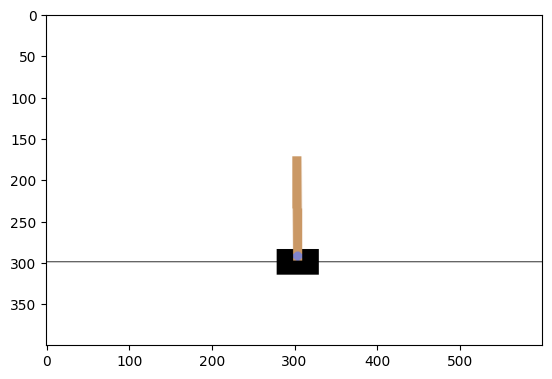

In [43]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())

In [44]:
class DQN(nn.Module):
    def __init__(self,n_actions,n_states):
        super(DQN,self).__init__()
        
        self.f = nn.Sequential(
            nn.Linear(n_states,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,n_actions)
        )
    def forward(self,state):
        action_value = self.f(state)
        return action_value

In [45]:
Q = DQN(2,4).to(device)
static_Q = DQN(2,4).to(device)
static_Q.load_state_dict(Q.state_dict())

<All keys matched successfully>

In [46]:
def select_action(state,epsilon = 1e-6):
    state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [47]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 1000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

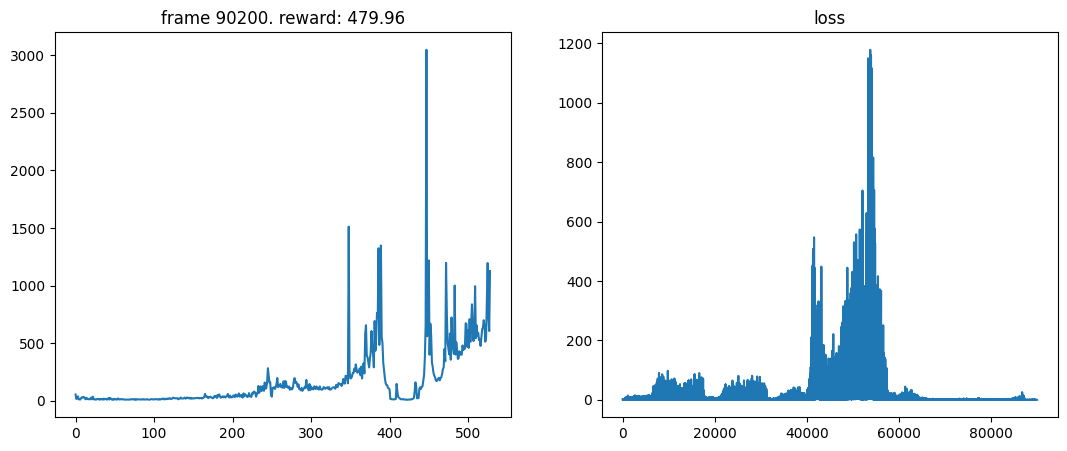

DONE


In [48]:
replaybuffer = ReplayBuffer(max_capacity=10000,batch_size=16)
alpha = 0.5
beta = 0.5
num_steps = 1000000
gamma = 0.99
optimizer = torch.optim.Adam(Q.parameters(),lr=1e-4)
average_game_reward = []
losses = []
game_reward = 0
state,info = env.reset()
for t in tqdm(range(num_steps)):
    epsilon = epsilon_by_frame(t)
    action = select_action(state,epsilon=epsilon)
    next_state,reward,done,_,info = env.step(action)
    replaybuffer.add(state,action,reward,next_state,done)
    state = next_state
    game_reward += reward
    if done:
        state,info = env.reset()
        average_game_reward.append(game_reward)
        game_reward = 0
    
    
        
    
    if  len(replaybuffer)> 200:
        s,action,reward,next_state,done,sample_weights,sample_idxs = replaybuffer.sample_transition(alpha=alpha,beta=beta)
        
        
        s = torch.from_numpy(s).to(device)
        action = torch.tensor(action).to(device)
        reward = torch.tensor(reward).to(device)
        next_state = torch.from_numpy(next_state).to(device)
        not_done =torch.tensor(1-np.array(done)).to(device)
        sample_weights = torch.tensor(sample_weights).to(device)

        target = reward + not_done * (gamma * torch.max(static_Q(next_state).detach(),dim=1)[0])
        prediction = Q(s)
        prediction = prediction[range(len(action)),action]
        loss = (target - prediction).pow(2) * sample_weights
        pr = loss.detach().cpu().numpy()+1e-6
        loss = loss.mean()
        for idx,p in zip(sample_idxs,pr):
            replaybuffer.priority[idx] = p 
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(Q.parameters(),5000)
        optimizer.step()
        losses.append(loss.item())
        static_Q.load_state_dict(Q.state_dict())
        if t % 200 == 0:
            plot(t,average_game_reward,losses)

            if np.mean(average_game_reward[-100:]) > env.spec.reward_threshold:
                print('DONE')
                break

In [49]:
env_2 = gym.make('CartPole-v1',render_mode = 'rgb_array')
env_2 = gym.wrappers.RecordVideo(env_2,'.',episode_trigger=lambda x:True)
for episode in range(5):
    state,info = env_2.reset()
    rewards = 0
    while True:
        action = select_action(state,epsilon=0)
        next_state,reward,done,_,info = env_2.step(action)
        if done:
            break
        state = next_state
        rewards+= reward
    print('rewad',rewards)
env_2.close()

/home/cerenov/anaconda3/envs/RL/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/cerenov/PROJECTS/RL/RL algos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-0.mp4
rewad 978.0
Moviepy - Building video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-1.mp4.
Moviepy - Writing video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-1.mp4
rewad 869.0
Moviepy - Building video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-2.mp4.
Moviepy - Writing video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-2.mp4
rewad 419.0
Moviepy - Building video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-3.mp4.
Moviepy - Writing video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-3.mp4
rewad 1018.0
Moviepy - Building video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-4.mp4.
Moviepy - Writing video /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/cerenov/PROJECTS/RL/RL algos/rl-video-episode-4.mp4
rewad 1173.0


# Atari Pong DDQN

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/cerenov/anaconda3/envs/RL/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


actions Discrete(6)
observation Box(0, 255, (210, 160, 3), uint8)


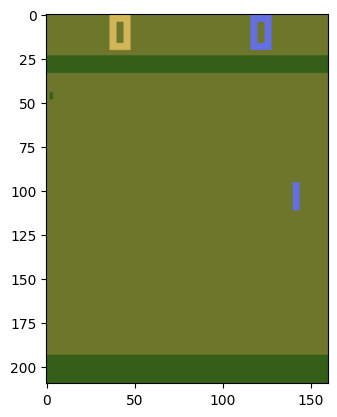

In [7]:
env = gym.make('PongNoFrameskip-v4',render_mode = 'rgb_array')
state,info = env.reset()
print('actions',env.action_space)
print('observation',env.observation_space)
plt.imshow(env.render())
plt.show()

In [8]:
class ConvDQN(nn.Module):
    def __init__(self,n_actions):
        super(ConvDQN,self).__init__()
        self.q = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=8,stride=4),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2592,256),
            nn.ReLU(),
            nn.Linear(256,n_actions)
        )
        
    def forward(self,state):
        q_value = self.q(state)
        return q_value

In [9]:
env = AtariPreprocessing(env,scale_obs=True,grayscale_newaxis=False,grayscale_obs=True)

In [10]:
def select_action(state,epsilon = 1e-6):
    
    state = torch.from_numpy(state).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    
    if random.random() < epsilon:
        return random.randrange(env.action_space.n)
    else:
        action = torch.argmax(Q(state),dim=1)
        return action.item()

In [11]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 40000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [12]:
beta_start = 0.4
beta_frames = 100000
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

In [13]:
def train(Q,static_Q,num_time_steps,env,batch_size,replay_buffer_size = 2000,gamma = 0.99,lr = 1e-4,alpha=0.5,beta =0.6):

    replay_buffer = ReplayBuffer(max_capacity=replay_buffer_size,batch_size=batch_size)
    optimizer = torch.optim.Adam(Q.parameters(),lr = lr)
    epsilon = 1.0
    reward_per_t = []
    losses = []
    t_reward = 0
    state,info = env.reset()
    for t in range(1,num_time_steps):
        epsilon = epsilon_by_frame(t)
        action = select_action(state,epsilon)
        next_state,reward,done,_,info = env.step(action)
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        t_reward+=reward
        if done:
            state,info = env.reset()
            reward_per_t.append(t_reward)
            t_reward =0
        
        
        if len(replay_buffer) > 10000:
            beta = beta_by_frame(t)
            s,action,reward,n_s,done,sample_weights,sample_idxs = replay_buffer.sample_transition(alpha=alpha,beta=beta)
            s = torch.from_numpy(s).unsqueeze(dim=1).type(torch.float32).to(device)
            action = torch.tensor(action).to(device)
            reward = torch.tensor(reward).to(device)
            n_s = torch.from_numpy(n_s).unsqueeze(dim=1).type(torch.float32).to(device)
            not_done =torch.tensor(1-np.array(done)).to(device)
            sample_weights = torch.tensor(sample_weights).to(device)
            next_max_value_action = torch.argmax(Q(n_s),dim=1)
            target = reward + not_done * gamma*static_Q(n_s).detach()[range(len(next_max_value_action)),next_max_value_action]
            prediction = Q(s)
            prediction = prediction[range(len(action)),action]
            loss = (target - prediction).pow(2) * sample_weights
            pr = loss.detach().cpu().numpy()+1e-6
            loss = loss.mean()
            for idx,p in zip(sample_idxs,pr):
                replay_buffer.priority[idx] = p 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if t % 200 == 0:
                static_Q.load_state_dict(Q.state_dict())
        if np.mean(reward_per_t[-10:]) > 20:
            print('Solved')
            break
        if t % 10000 == 0:
            plot(t,reward_per_t,losses)
            print(f'epsilon {epsilon:.2f}')

In [14]:
Q = ConvDQN(6).to(device)
static_Q = ConvDQN(6).to(device)
static_Q.load_state_dict(Q.state_dict())

<All keys matched successfully>

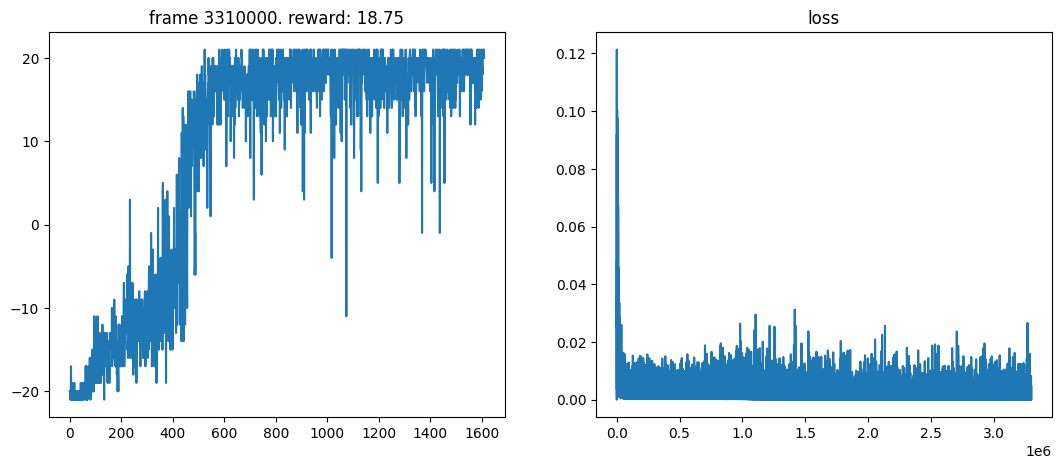

epsilon 0.01
Solved


In [15]:
train(Q,static_Q,10000000,env,batch_size=32,replay_buffer_size=100000)